# 1. Introduction

WEDO's mission is to create sustainable and purposeful innovations using voice technology that is more fair and more open to everyone. We have developed our own voice command system and embedded it into smart home appliances, such as speakers and faucets, for better living. In addition, we are building “a voice-enabled device equipped with a camera for blind people” to guide them directions while walking on a street. Thanks to Mozilla Common Voice and its open-source datasets, we are able to build incredible things that have a positive impact on people's lives. This motivates us to build a speech to text (STT) model with gender inclusive performance. More precisely, our STT model should perform equally well for both male and female.

First, we explored the Common Voice 11 dataset. It seemed that there was gender bias. Total data are 135,897 files, which are composed of 52,769 files for male, 30,283 files for female, 1,821 files of other gender, and  51,024 files for undefined gender. This meant that female data was about one-third smaller than male data. As a result, if the model trained with the male-dominant data, the model tended to be biased to male voices. Thus, we tried to find ways to build the gender-inclusive model. However, the experiments showed that our models were not biased toward male voices. In fact, we can recognize female voices slightly better than male voices in most cases of our experiments.

Our contributions can be summarized as follows.

1. We perform an exploratory data analysis to understand data bias over gender in the Common Voice 11 dataset.
2. We propose a STT for Thai, which is fine-tuned on Data2Vec, a state-of-the-art for self-supervised learning in speech.
3. We conduct an experiment to understand performance bias possibly caused by data bias in the Common Voice 11 dataset.
4. To augment Common Voice 11 data, we propose a gender classification model that can infer a gender with F1-score of 0.95.
5. Finally, we did a further analysis to validate various assumptions about performance bias due to data bias between male and female.


# 2. Exploratory Data Analysis (EDA)

 For the STT study, we use only the validated set of the Common Voice 11 dataset. Note that, not all data in the validated set contains gender information. All data for STT will be stored in "data/commonvoice11" after running the script "load_commonvoice11.sh".

 For the gender classification study, we use only a subset of the Common Voice 11 dataset, which contains gender information. In addition, we also use the Thai SER (Speech Emotion Recognition) dataset, which is provided with gender labels. All data for gender classification will be stored in "data/thai_ser" after running the script "load_thai_ser.sh".

In [ ]:
import pandas as pd
import os

In [2]:
df_all_data = pd.read_csv("data/commonvoice11/annotation/validated.tsv", sep='\t')

/Users/kongpolc/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The total number of data in the validated set is 135,897 files. We observed that some data have no information about gender and the distribution of genders is not balanced. We showed the distribution of data below.

 **Remarks:** The gender information is crucial for this study. For those data with gender labeled as null, we assigned "not-filling" as value.

In [3]:
#Duplicate removal: same person should not speak same sentence

rm_dp_df_all = df_all_data.drop_duplicates(subset=["sentence", "client_id"], keep="first")

print("no. all data:",len(rm_dp_df_all))

rm_dp_df_all[['gender']] = rm_dp_df_all[['gender']].fillna(value="not_filling")

print("no. gender data:\n", rm_dp_df_all["gender"].value_counts())

no all data: 135897
no gender data:
 male           52769
not_filling    51024
female         30283
other           1821
Name: gender, dtype: int64


In [4]:
# get the whole data ratio

male_ratio = len(rm_dp_df_all[rm_dp_df_all["gender"] == "male"])/len(rm_dp_df_all)
female_ratio = len(rm_dp_df_all[rm_dp_df_all["gender"] == "female"])/len(rm_dp_df_all)
other_ratio = len(rm_dp_df_all[rm_dp_df_all["gender"] == "other"])/len(rm_dp_df_all)
not_filling_ratio = len(rm_dp_df_all[rm_dp_df_all["gender"] == "not_filling"])/len(rm_dp_df_all)
print("no. gender ratio:", sum([male_ratio, female_ratio, other_ratio, not_filling_ratio]))
print("male ratio:",  male_ratio)
print("female ratio:", female_ratio)
print("other ratio:", other_ratio)
print("not_filling ratio:", not_filling_ratio)

no gender ratio: 1.0
male ratio: 0.3883014341744115
female ratio: 0.22283788457434675
other ratio: 0.013399854301419458
not_filling ratio: 0.3754608269498223


# 3. Data Preparation

From the data distribution above, it is clear that the majority of data came from the male gender. To study the impact of gender-unbalanced data on STT, we divided the data into 3 datasets, where the detail of each dataset is given below.
since we assumed this data should be made biased toward a male voice more than a female voice
 
1. **Dataset 1:** We split the whole validated set into 3 parts (train, dev, and test) using the ratio below.
* train_ratio = **0.85** [gender ratio: male 38%, female 22%, other 1.3%, and not_filling 3.7%]
* dev_ratio = **0.05** [gender ratio: male 38%, female 22%, other 1.3%, and not_filling 3.7%]
* test_ratio = **0.10** [gender ratio: male 38%, female 22%, other 1.3%, and not_filling 3.7%]
 
2. **Dataset 2:** We further process Dataset 1 by balancing the amount of data to be equal for both male and female in all parts (train, dev, and test). Note that, we exclude "other" and "not_filling" classes because we do not know the exact gender.
* train_ratio = **0.85** [gender ratio: male 50%, female 50%]
* dev_ratio = **0.05** [gender ratio: male 50%, female 50%]
* test_ratio = **0.10** [gender ratio: male 50%, female 50%]
 
3. **Dataset 3:** We further process Dataset 1 by considering sentences that are spoken by both male and female, and also balancing the number of samples from both genders in the selected sentences, i.e., implying no data bias exists on sentence level.
* train_ratio = **0.85** [gender ratio: male 50%, female 50%]
* dev_ratio = **0.05** [gender ratio: male 50%, female 50%]
* test_ratio = **0.10** [gender ratio: male 50%, female 50%]

Note, the difference between Dataset 2 and Dataset 3 are the total number of samples.
* Dataset 2 has 60,560 samples.
* Dataset 3 has 24,852 samples.

In [48]:
# setting data ratio
train_ratio = 0.85
dev_ratio = 0.05
test_ratio = 0.10

### 3.1 Dataset 1 Seperation

In [49]:
# seperator function, this function can separate data with group data ratio.
def seperator(total_ratio, class_ratio, df_all):
    no_total = total_ratio*len(rm_dp_df_all)

    all_df_class_list = []
    df_the_rest =  df_all
    for key in class_ratio:
        no_each_class = int(class_ratio[key]*no_total)
        
        df_tmp = df_the_rest[df_the_rest["gender"]==key]
        df_tmp = df_the_rest.sample(n=no_each_class, random_state=47, replace=False)
        df_the_rest = pd.concat([df_the_rest, df_tmp]).drop_duplicates(subset=["sentence", "client_id"], keep=False)
        
        all_df_class_list.append(df_tmp)
    df_out_data = pd.concat(all_df_class_list)
        
    return df_out_data, df_the_rest

In [50]:
# train seperation
df_train, df_the_rest_sofar = seperator(train_ratio, {'male': male_ratio, 'female': female_ratio, 'other': other_ratio, 'not_filling': not_filling_ratio},rm_dp_df_all)
# dev seperation
df_dev, df_the_rest_sofar = seperator(dev_ratio, {'male': male_ratio, 'female': female_ratio, 'other': other_ratio, 'not_filling': not_filling_ratio},df_the_rest_sofar)
# test seperation
df_test, df_the_rest_sofar = seperator(test_ratio, {'male': male_ratio, 'female': female_ratio, 'other': other_ratio, 'not_filling': not_filling_ratio},df_the_rest_sofar)


In [51]:
print("Actual no. data: ")
print("Train:", len(df_train))
print(df_train["gender"].value_counts())
print("Dev:", len(df_dev))
print(df_dev["gender"].value_counts())
print("Test:", len(df_test))
print(df_test["gender"].value_counts())

Actual no data: 
Train: 115510
male           44821
not_filling    43326
female         25825
other           1538
Name: gender, dtype: int64
Dev: 6794
male           2625
not_filling    2567
female         1517
other            85
Name: gender, dtype: int64
Test: 13588
male           5322
not_filling    5130
female         2938
other           198
Name: gender, dtype: int64


In [9]:
# export the first data set
os.makedirs('data/commonvoice11/annotation/dataset_1', exist_ok=True)

df_train.to_csv("data/commonvoice11/annotation/dataset_1/train.csv", index=False)
df_dev.to_csv("data/commonvoice11/annotation/dataset_1/dev.csv", index=False)
df_test.to_csv("data/commonvoice11/annotation/dataset_1/test.csv", index=False)

### 3.2 Dataset 2 Seperation

In [10]:
# Read the first data set
df_normal_train = pd.read_csv("data/commonvoice11/annotation/dataset_1/train.csv")
df_normal_dev = pd.read_csv("data/commonvoice11/annotation/dataset_1/dev.csv")
df_normal_test = pd.read_csv("data/commonvoice11/annotation/dataset_1/test.csv")

In [14]:
# keeping data only male and female
df_balance_train = df_normal_train[df_normal_train["gender"]!="not_filling"]
df_balance_train = df_balance_train[df_balance_train["gender"]!="other"]

df_balance_dev = df_normal_dev[df_normal_dev["gender"]!="not_filling"]
df_balance_dev = df_balance_dev[df_balance_dev["gender"]!="other"]

df_balance_test = df_normal_test[df_normal_test["gender"]!="not_filling"]
df_balance_test = df_balance_test[df_balance_test["gender"]!="other"]

In [15]:
# distribution after remove not gender filling and other
display(df_balance_train["gender"].value_counts())
display(df_balance_dev["gender"].value_counts())
display(df_balance_test["gender"].value_counts())

male      44821
female    25825
Name: gender, dtype: int64

male      2625
female    1517
Name: gender, dtype: int64

male      5322
female    2938
Name: gender, dtype: int64

In [16]:
# Sampling balance train data
no_female_in_train = len(df_balance_train[df_balance_train["gender"] =="female"])

df_female_train = df_balance_train[df_balance_train["gender"]=="female"]
df_male_train = df_balance_train[df_balance_train["gender"]=="male"].sample(frac=1, replace=False, random_state=47)
df_male_train.reset_index(inplace = True, drop=True)
df_male_train = df_male_train[0:no_female_in_train]

df_out_balance_train = pd.concat([df_male_train, df_female_train])
df_out_balance_train["gender"].value_counts()

male      25825
female    25825
Name: gender, dtype: int64

In [17]:
# Sampling balance test data
no_female_in_test = len(df_balance_test[df_balance_test["gender"] =="female"])
df_female_test = df_balance_test[df_balance_test["gender"]=="female"]
df_male_test = df_balance_test[df_balance_test["gender"]=="male"].sample(frac=1, replace=False, random_state=47)
df_male_test.reset_index(inplace = True, drop=True)
df_male_test = df_male_test[0:no_female_in_test]

df_out_balance_test = pd.concat([df_male_test, df_female_test])
df_out_balance_test["gender"].value_counts()

male      2938
female    2938
Name: gender, dtype: int64

In [18]:
# Sampling balance dev data
no_female_in_dev = len(df_balance_dev[df_balance_dev["gender"] =="female"])

df_female_dev = df_balance_dev[df_balance_dev["gender"]=="female"]
df_male_dev = df_balance_dev[df_balance_dev["gender"]=="male"].sample(frac=1, replace=False, random_state=47)
df_male_dev.reset_index(inplace = True, drop=True)
df_male_dev = df_male_dev[0:no_female_in_dev]

df_out_balance_dev = pd.concat([df_male_dev, df_female_dev])
df_out_balance_dev["gender"].value_counts()

male      1517
female    1517
Name: gender, dtype: int64

In [19]:
# distribution of second data set
display(df_out_balance_train["gender"].value_counts())
display(df_out_balance_dev["gender"].value_counts())
display(df_out_balance_test["gender"].value_counts())

male      25825
female    25825
Name: gender, dtype: int64

male      1517
female    1517
Name: gender, dtype: int64

male      2938
female    2938
Name: gender, dtype: int64

In [20]:
# export second data set
os.makedirs('data/commonvoice11/annotation/dataset_2', exist_ok=True)

df_out_balance_train.to_csv("data/commonvoice11/annotation/dataset_2/train.csv", index=False)
df_out_balance_dev.to_csv("data/commonvoice11/annotation/dataset_2/dev.csv", index=False)
df_out_balance_test.to_csv("data/commonvoice11/annotation/dataset_2/test.csv", index=False)

### 3.3 Dataset 3 Seperation

In [38]:
# Read second data set
df_normal_train = pd.read_csv("data/commonvoice11/annotation/dataset_1/train.csv")
df_normal_dev = pd.read_csv("data/commonvoice11/annotation/dataset_1/dev.csv")
df_normal_test = pd.read_csv("data/commonvoice11/annotation/dataset_1/test.csv")

In [40]:
# keeping data only male and female
df_balance_same_train = df_normal_train[df_normal_train["gender"]!="not_filling"]
df_balance_same_train = df_balance_same_train[df_balance_same_train["gender"]!="other"]

df_balance_same_dev = df_normal_dev[df_normal_dev["gender"]!="not_filling"]
df_balance_same_dev = df_balance_same_dev[df_balance_same_dev["gender"]!="other"]

df_balance_same_test = df_normal_test[df_normal_test["gender"]!="not_filling"]
df_balance_same_test = df_balance_same_test[df_balance_same_test["gender"]!="other"]

In [ ]:
os.makedirs('data/commonvoice11/annotation/dataset_3', exist_ok=True)

In [42]:
# sampling balance train data and same sentence
df_balance_same_train["duplicated"] = df_balance_same_train.duplicated(subset=["sentence"], keep=False) # duplicate with 2 conditions
df_balance_same_train = df_balance_same_train[df_balance_same_train["duplicated"] == True]

df_balance_male_train = df_balance_same_train[df_balance_same_train["gender"] == "male"]
df_balance_female_train = df_balance_same_train[df_balance_same_train["gender"] == "female"]


df_balance_male_train.drop_duplicates(subset=["sentence"], keep="first", inplace=True)
df_balance_female_train.drop_duplicates(subset=["sentence"], keep="first", inplace=True)

df_balance_male_train = df_balance_male_train[df_balance_male_train["sentence"].isin(df_balance_female_train["sentence"])]
df_balance_female_train = df_balance_female_train[df_balance_female_train["sentence"].isin(df_balance_male_train["sentence"])]

df_balance_all_train = pd.concat([df_balance_male_train, df_balance_female_train])

df_balance_all_train.to_csv("data/commonvoice11/annotation/dataset_3/train.csv", index=False)

print(df_balance_all_train["gender"].value_counts())

/Users/kongpolc/opt/anaconda3/envs/stt/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


male      12149
female    12149
Name: gender, dtype: int64


In [44]:
# sampling balance dev data and same sentence
df_balance_same_dev["duplicated"] = df_balance_same_dev.duplicated(subset=["sentence"], keep=False) # duplicate with 2 conditions
df_balance_same_dev = df_balance_same_dev[df_balance_same_dev["duplicated"] == True]

df_balance_male_dev = df_balance_same_dev[df_balance_same_dev["gender"] == "male"]
df_balance_female_dev = df_balance_same_dev[df_balance_same_dev["gender"] == "female"]


df_balance_male_dev.drop_duplicates(subset=["sentence"], keep="first", inplace=True)
df_balance_female_dev.drop_duplicates(subset=["sentence"], keep="first", inplace=True)

df_balance_male_dev = df_balance_male_dev[df_balance_male_dev["sentence"].isin(df_balance_female_dev["sentence"])]
df_balance_female_dev = df_balance_female_dev[df_balance_female_dev["sentence"].isin(df_balance_male_dev["sentence"])]

df_balance_all_dev = pd.concat([df_balance_male_dev, df_balance_female_dev])

df_balance_all_dev.to_csv("data/commonvoice11/annotation/dataset_3/dev.csv", index=False)

print(df_balance_all_dev["gender"].value_counts())

male      74
female    74
Name: gender, dtype: int64


/Users/kongpolc/opt/anaconda3/envs/stt/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [45]:
# sampling balance test data
df_balance_same_test["duplicated"] = df_balance_same_test.duplicated(subset=["sentence"], keep=False) # duplicate with 2 conditions
df_balance_same_test = df_balance_same_test[df_balance_same_test["duplicated"] == True]

df_balance_male_test = df_balance_same_test[df_balance_same_test["gender"] == "male"]
df_balance_female_test = df_balance_same_test[df_balance_same_test["gender"] == "female"]


df_balance_male_test.drop_duplicates(subset=["sentence"], keep="first", inplace=True)
df_balance_female_test.drop_duplicates(subset=["sentence"], keep="first", inplace=True)

df_balance_male_test = df_balance_male_test[df_balance_male_test["sentence"].isin(df_balance_female_test["sentence"])]
df_balance_female_test = df_balance_female_test[df_balance_female_test["sentence"].isin(df_balance_male_test["sentence"])]

df_balance_all_test = pd.concat([df_balance_male_test, df_balance_female_test])

df_balance_all_test.to_csv("data/commonvoice11/annotation/dataset_3/test.csv", index=False)

print(df_balance_all_test["gender"].value_counts())

male      203
female    203
Name: gender, dtype: int64


In [46]:
# distribution of third data set
display(df_balance_all_train["gender"].value_counts())
display(df_balance_all_dev["gender"].value_counts())
display(df_balance_all_test["gender"].value_counts())

male      12149
female    12149
Name: gender, dtype: int64

male      74
female    74
Name: gender, dtype: int64

male      203
female    203
Name: gender, dtype: int64

### Summarize the Distribution of Datasets 1-3

In [47]:
print("Data 1 ")
print("Train:", len(df_train))
print(df_train["gender"].value_counts())
print("Dev:", len(df_dev))
print(df_dev["gender"].value_counts())
print("Test:", len(df_test))
print(df_test["gender"].value_counts())
print("----------------------------")
print("Data 2 ")
print("Train:", len(df_out_balance_train))
print(df_out_balance_train["gender"].value_counts())
print("Dev:", len(df_out_balance_dev))
print(df_out_balance_dev["gender"].value_counts())
print("Test:", len(df_out_balance_test))
print(df_out_balance_test["gender"].value_counts())
print("----------------------------")
print("Data 3 ")
print("Train:", len(df_balance_all_train))
print(df_balance_all_train["gender"].value_counts())
print("Dev:", len(df_balance_all_dev))
print(df_balance_all_dev["gender"].value_counts())
print("Test:", len(df_balance_all_test))
print(df_balance_all_test["gender"].value_counts())

Data 1 
Train: 115510
male           44821
not_filling    43326
female         25825
other           1538
Name: gender, dtype: int64
Dev: 6794
male           2625
not_filling    2567
female         1517
other            85
Name: gender, dtype: int64
Test: 13588
male           5322
not_filling    5130
female         2938
other           198
Name: gender, dtype: int64
----------------------------
Data 2 
Train: 51650
male      25825
female    25825
Name: gender, dtype: int64
Dev: 3034
male      1517
female    1517
Name: gender, dtype: int64
Test: 5876
male      2938
female    2938
Name: gender, dtype: int64
----------------------------
Data 3 
Train: 24298
male      12149
female    12149
Name: gender, dtype: int64
Dev: 148
male      74
female    74
Name: gender, dtype: int64
Test: 406
male      203
female    203
Name: gender, dtype: int64


# 4. Model and Evaluation

To study the equity and fairness of STT for Thai, we proposed two different models that will be used in our experiments.

* First, a STT for Thai is fine-tuned on Data2Vec, which is a state-of-the-art for self-supervised learning in speech. We will assess the STT performance among male and female in using Dataset 1, Dataset 2 and Dataset 3, accordingly.

* Second, a speech gender classification model is used to infer gender for Dataset 2 and Dataset 3 in order to increase the amount of training data. We hope that leveraging gender classification will helps mitigate WER and CER biases between genders, and improve WER and CER in general.

### 4.1 Speech-To-Text Model

To reproduce our STT work, please refer to the detailed instruction and code located in the STT folder under this repository.
* [https://github.com/KongpolC/our-voices-model-competition/tree/main/submit/Gender_Category/STT].

We conducted two main steps in order to study gender bias in STT for Thai:

1. Model Training: We fine-tuned a Data2Vec model with 3 datasets defined above (Dataset 1, Dataset 2 and Dataset 3); thus resulting in 3 different models. 

2. Model Evaluation: We evaluated our 3 STT models by measuring WER & CER using 3 test sets from Dataset 1, Dataset 2 and Dataset 3, accordingly.

In the following, we provide an overview of model training, data, and evaluation. 

**Model**
 
* Data2Vec (Ref.: https://huggingface.co/docs/transformers/model_doc/data2vec)
 
**Training Data**
 
We trained 3 models using 3 different datasets described above.
 
* Dataset 1 (Unbalanced ratio among 4 classes of genders)
 
* Dataset 2 (Balanced ratio between female & male)
 
* Dataset 3 (Balanced ratio between female & male by considering sentences spoken by both genders)
 
**Evaluation**
 
All three models were evaluated with test sets from Datasets 1, 2 & 3 to find insights and identify
performance bias across genders.
 
The metrics used are Word Error Rate (WER) and Character Error Rate (CER). However, CER is used as a main metric due to the mistokenization issue when tokenizing Thai sentences for calculating WER. For instance,
 
* sentence: `ทรัสต์เพื่อการลงทุนในอสังหาริมทรัพย์`
* prediction: `ทรัสต์เพื่อการลงทนในอสังหาริมศัพท์`
* tokenized sentence: ['ทรัสต์', 'เพื่อ', 'การลงทุน', 'ใน', 'อสังหาริมทรัพย์']
* tokenized prediction: `['ทรัสต์', 'เพื่อ', 'การ', 'ลง', 'ทน', 'ใน', 'อสังหาริม', 'ศัพท์']`
* WER: 100%
* CER: 15%
 
It can be seen that the prediction misses only 2 words but the tokenizer splits those 2 words into 3 and 2 words (`'การลงทุน'` >> `'การ', 'ลง', 'ทน'` and `'อสังหาริมทรัพย์'` >> `'อสังหาริม', 'ศัพท์'`). This results in an unfairly high WER; thus CER is a preferred metric instead.

**Character Error Rate (CER)**

Same as WER, CER of female is slightly less than that of male in every models and test sets.

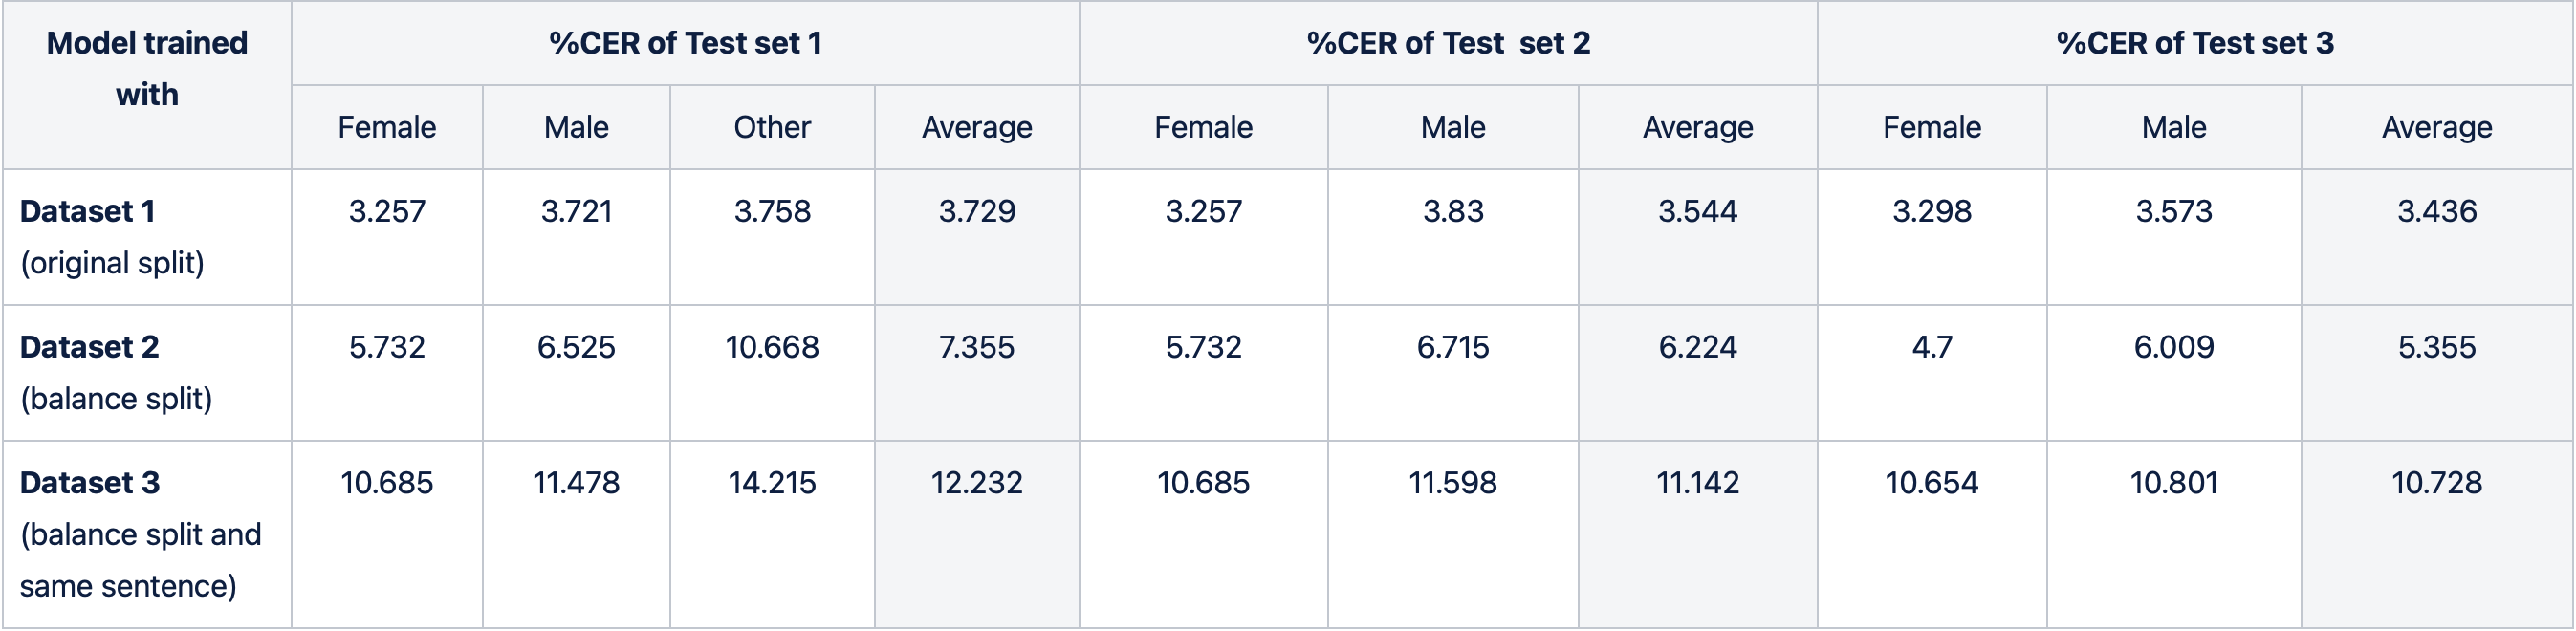

**Word Error Rate (WER)**

Table below shows that WER of female is slightly less than male in most models and test sets.

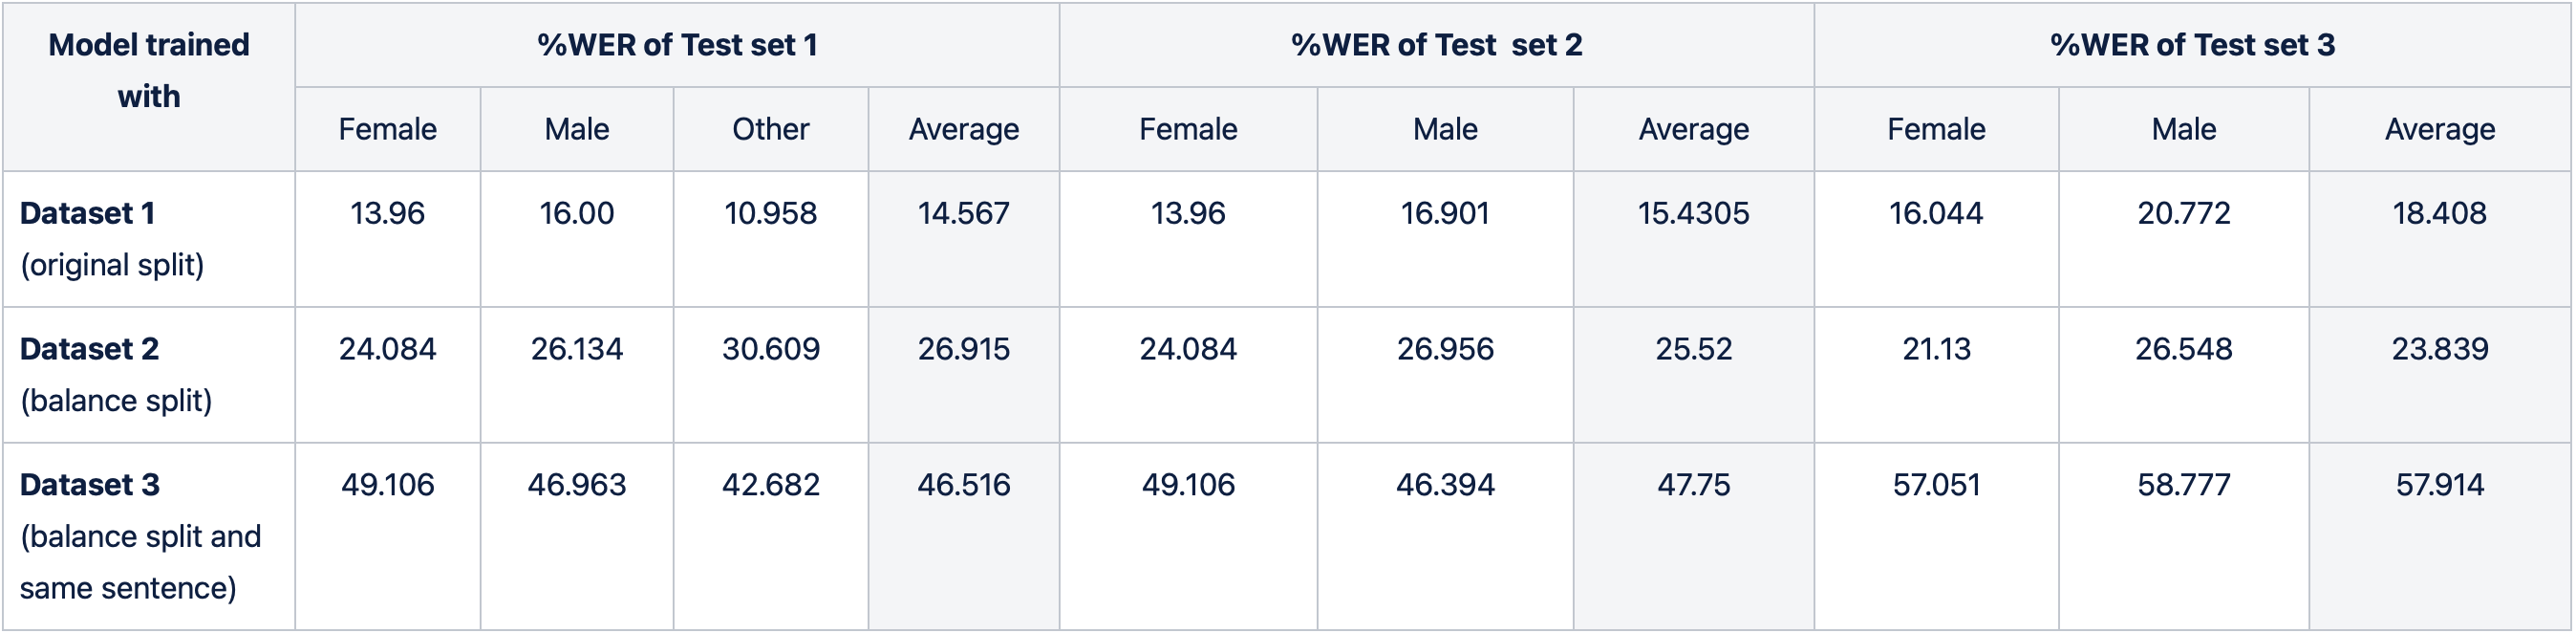

### 4.2 Speech Gender Classification Model
To reproduce our gender classification work, please refer to the detailed instruction and code located in the gender_classification folder under this repository.
* [https://github.com/KongpolC/our-voices-model-competition/tree/main/submit/Gender_Category/gender_classification].

**Model**

* Time Delay Neural Network (TDNN)

**Training**

Since we are working on Thai language, we need to train the model with a Thai dataset. Therefore, we used the following 2 datasets; (1) Common Voice 11 for thai, and (2) Thai-SER. Both dataset contain audio files in Thai, as well as, the associated gender.

Please refer to the links below for more information.

1. Commonvoice11-thai: https://commonvoice.mozilla.org/en/datasets
    * In this work, we used `data/commonvoice11/annotation/train.tsv`, `data/commonvoice11/annotation/dev.tsv`, `data/commonvoice11/annotation/test.tsv` and filter only the data gender labeled as either male or female.
    
2. Thai-SER (Speech Emotion Recognition): https://airesearch.in.th/releases/speech-emotion-dataset/


**Evaluation**

We conducted an evaluation to assess the classification performance using a combined test set generated from both datasets above.

Overall, our classification model can infer genders with an F1-score of 0.95. Therefore, our model is useful for augmenting the Common Voice 11 with missing gender information.

For the detailed result, please refer to the classification report below.

**Note**
To reproduce this reult, please execute `bash ./gender_classification/setup.sh` before. This script will download `gender_classification/models/prediction.csv` fro Google Drive.

In [ ]:
from sklearn.metrics import classification_report

model_testset_df = pd.read_csv("gender_classification/models/prediction.csv")

sample_level_cls_report_testset = classification_report(y_true=model_testset_df["Gt"], y_pred=model_testset_df["Pred"], labels=["Male", "Female"])

print(sample_level_cls_report_testset)

              precision    recall  f1-score   support

        Male       0.96      0.92      0.94      1978
      Female       0.93      0.97      0.95      2354

    accuracy                           0.95      4332
   macro avg       0.95      0.95      0.95      4332
weighted avg       0.95      0.95      0.95      4332



**Assigning gender to samples with gender labelled as "not-filling"**

Since Commonvoice11-thai also provides user-id, we can do a majority vote to assign gender for samples associated with the specific `client-id`.

1. Firstly, we let the model assign the gender to all samples.
* Then, we group samples by `client-id` and assign gender based on the maximum number of assigned gender of the specific user.
* Finally, we export the data as `gender_classification/models/commonvoice11_filled_gender.csv` having the predicted gender in `gender` column.

2. Secondly, to extract only new records, we filter only records from `data/commonvoice11/annotation/validated.tsv` having `gender` labelled as null to impute the predicted gender from `gender_classification/models/commonvoice11_filled_gender.csv`.

3. Thirdly, run the new data obtained previously through step 3.2 and 3.3 again but use all the data as train set to create 2 new datasets which are `data/commonvoice11/annotation/dataset_2_add_gender` and `data/commonvoice11/annotation/dataset_3_add_gender`.

### 4.3 Speech-To-Text Model with Additional Data (gender-filled)

After we added data that labelled gender by using our gender classification to the train sets of Dataset 1, 2 & 3. The data distribution can be seen below.

In [ ]:
# Read added data that labelled gender by using our gender classification to data train of sets 1-3
df_balanced_train = pd.read_csv("data/commonvoice11/annotation/dataset_2_add_gender/train.csv")
df_balanced_dev = pd.read_csv("data/commonvoice11/annotation/dataset_2/dev.csv")
df_balanced_test = pd.read_csv("data/commonvoice11/annotation/dataset_2/test.csv")

df_balanced_same_sentence_train = pd.read_csv("data/commonvoice11/annotation/dataset_3_add_gender/train.csv")
df_balanced_same_sentence_dev = pd.read_csv("data/commonvoice11/annotation/dataset_3/dev.csv")
df_balanced_same_sentence_test = pd.read_csv("data/commonvoice11/annotation/dataset_3/test.csv")

In [ ]:
print("Dataset 2 with imputed gender")
print("Train:", len(df_balanced_train))
print(df_balanced_train["gender"].value_counts())
print("\nDev:", len(df_balanced_dev))
print(df_balanced_dev["gender"].value_counts())
print("\nTest:", len(df_balanced_test))
print(df_balanced_test["gender"].value_counts())
print("\n----------------------------")
print("Data 3 with imputed gender")
print("Train:", len(df_balanced_same_sentence_train))
print(df_balanced_same_sentence_train["gender"].value_counts())
print("\nDev:", len(df_balanced_same_sentence_dev))
print(df_balanced_same_sentence_dev["gender"].value_counts())
print("\nTest:", len(df_balanced_same_sentence_test))
print(df_balanced_same_sentence_test["gender"].value_counts())

Data 1 
Test: 8458
male      5322
female    2938
other      198
Name: gender, dtype: int64

----------------------------
Data 2 
Train: 97918
male      48959
female    48959
Name: gender, dtype: int64

Dev: 3034
male      1517
female    1517
Name: gender, dtype: int64

Test: 5876
male      2938
female    2938
Name: gender, dtype: int64

----------------------------
Data 3 
Train: 42006
male      21003
female    21003
Name: gender, dtype: int64

Dev: 148
male      74
female    74
Name: gender, dtype: int64

Test: 406
male      203
female    203
Name: gender, dtype: int64


**Experimental Results**

In the following, we present a comparison among different models obtained from Dataset 1, 2 & 3 and Dataset 1, 2 & 3 (with augmented data from gender classification) are shown below.

**Word Error Rate (WER)**

Before and after upsampling with not_filling dataset

- Before

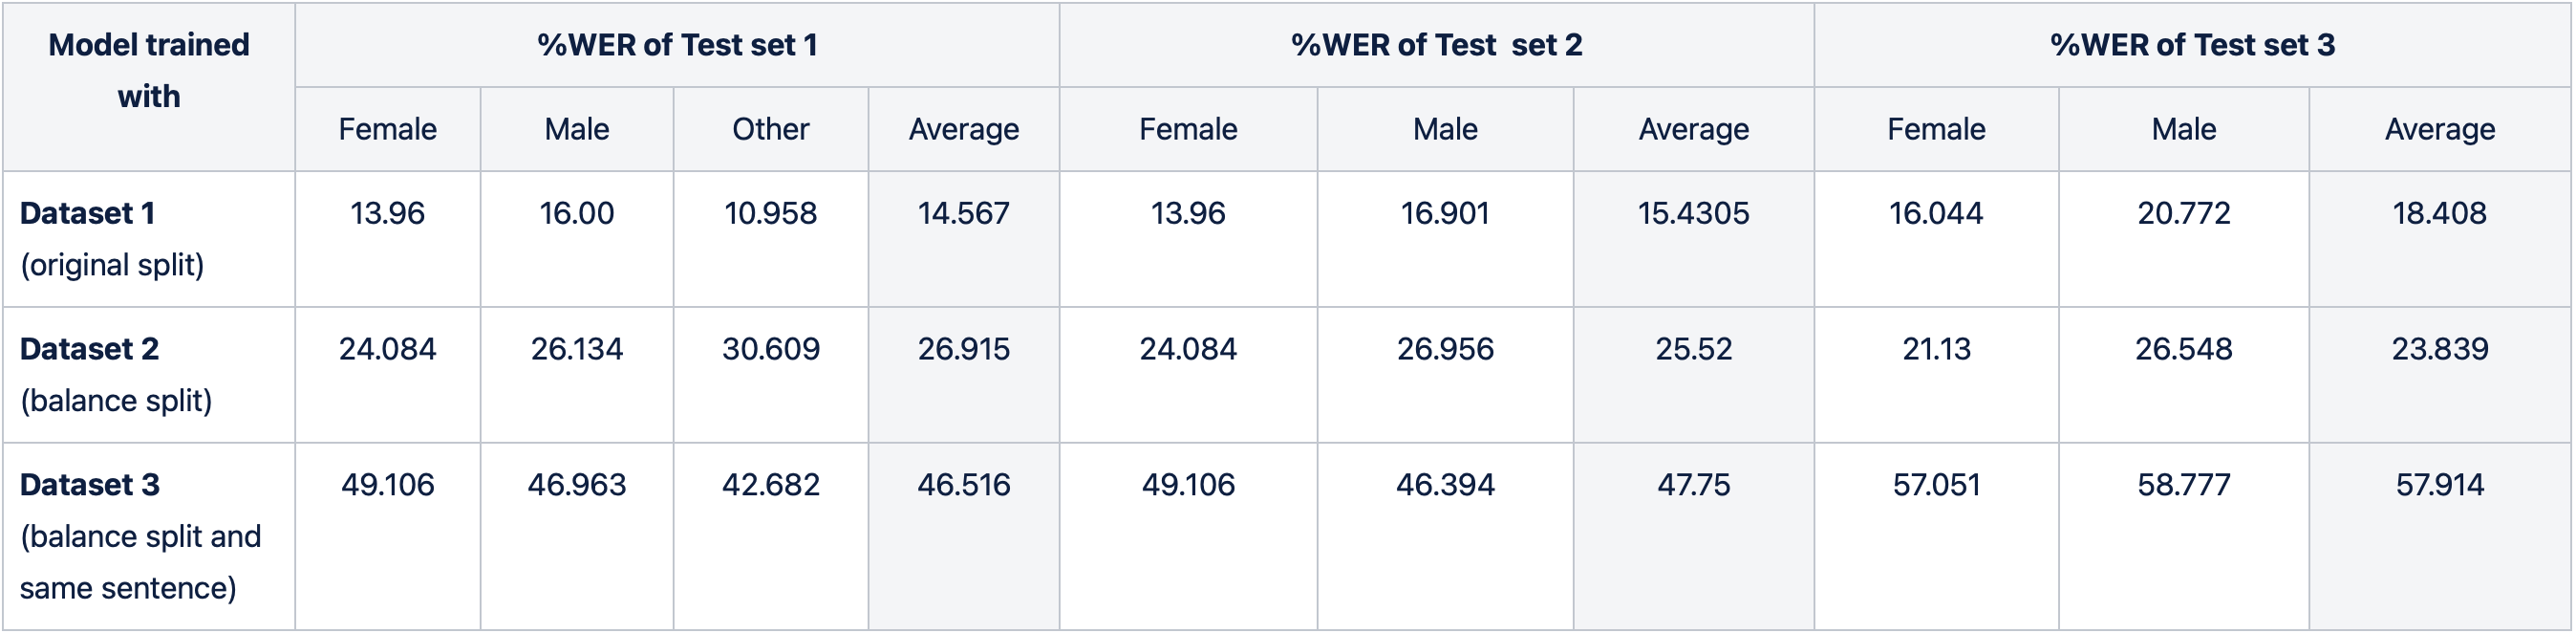

- After

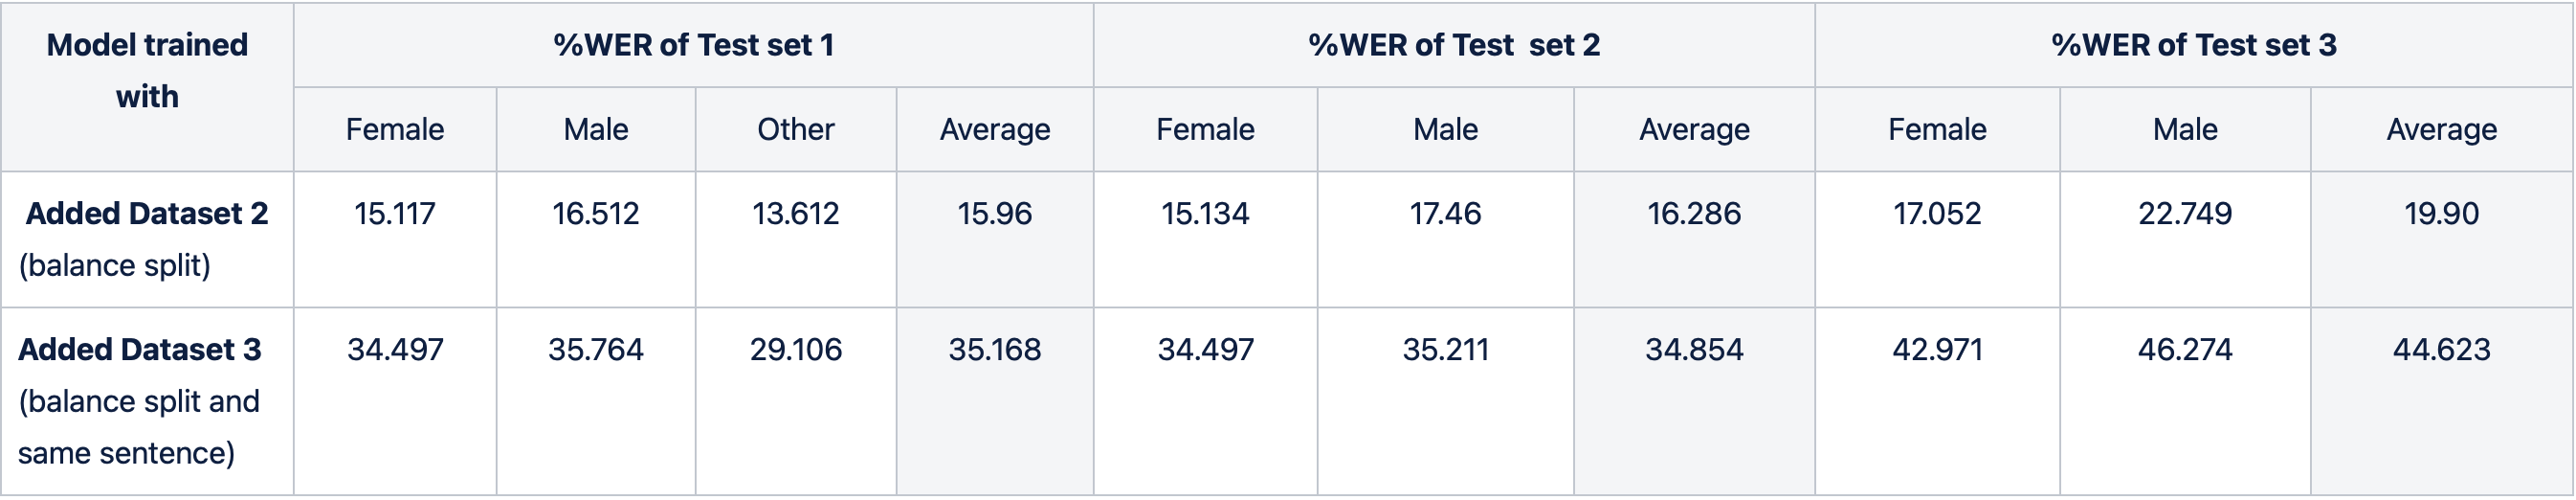

According to the reports, the overall performance is better with added training data. However, WER of females is still slightly less than males for 2 new models.



**Character Error Rate (CER)**

Before and after upsampling with not_filling dataset

- Before

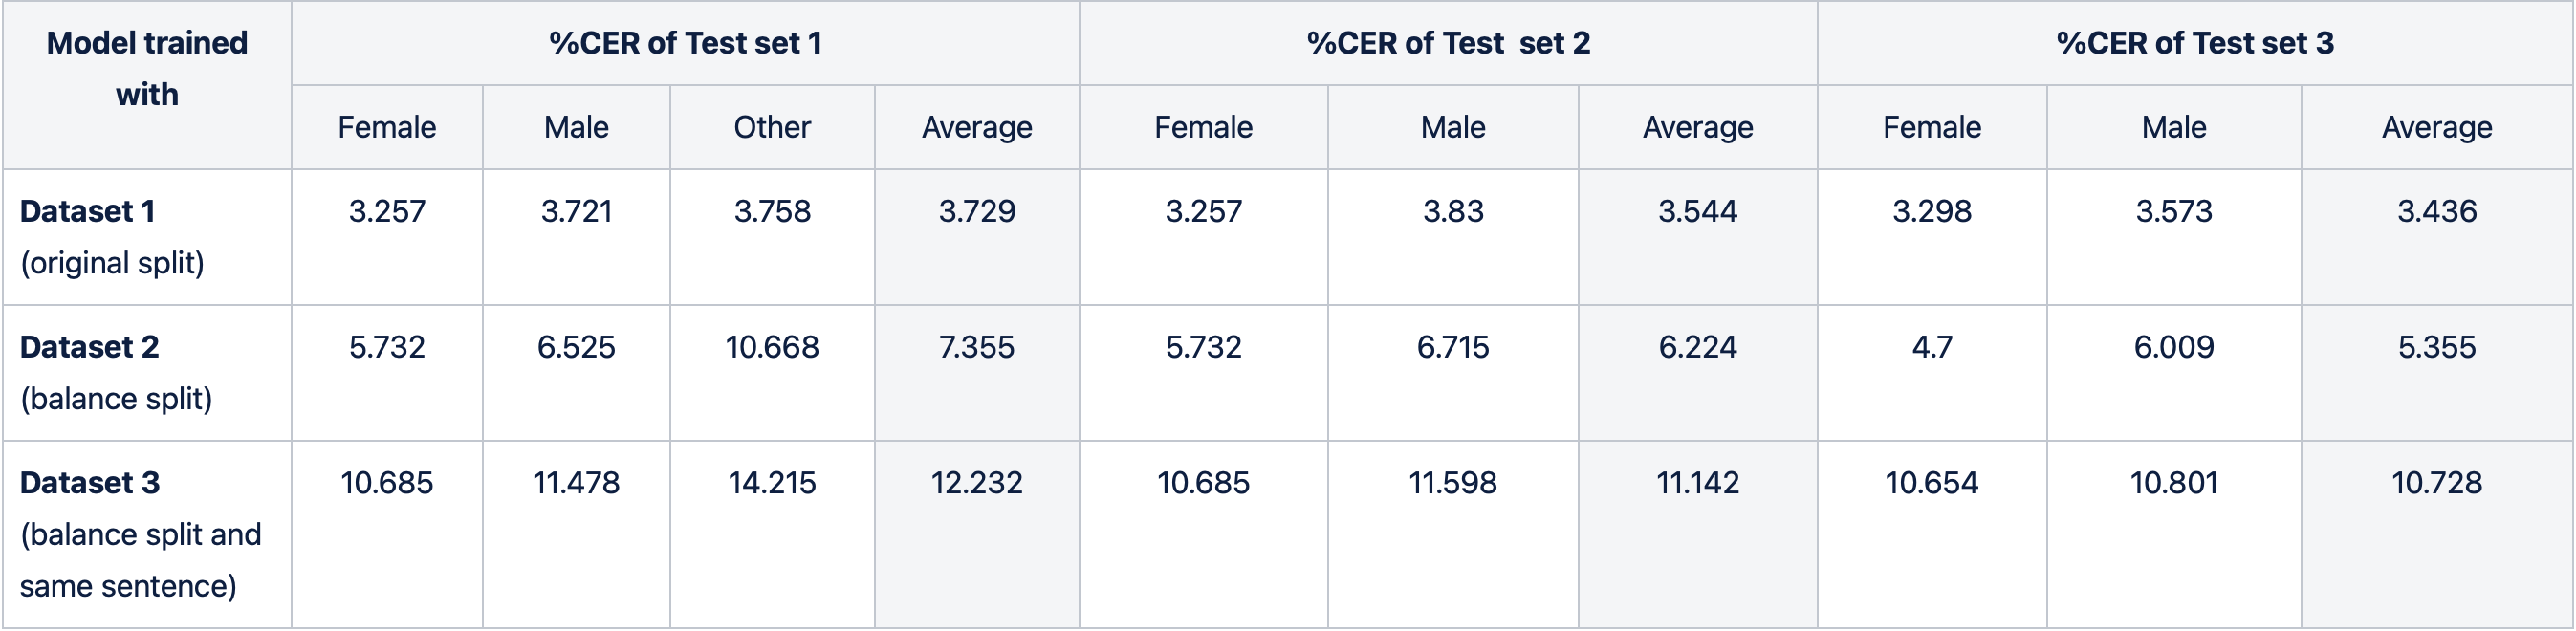

- After

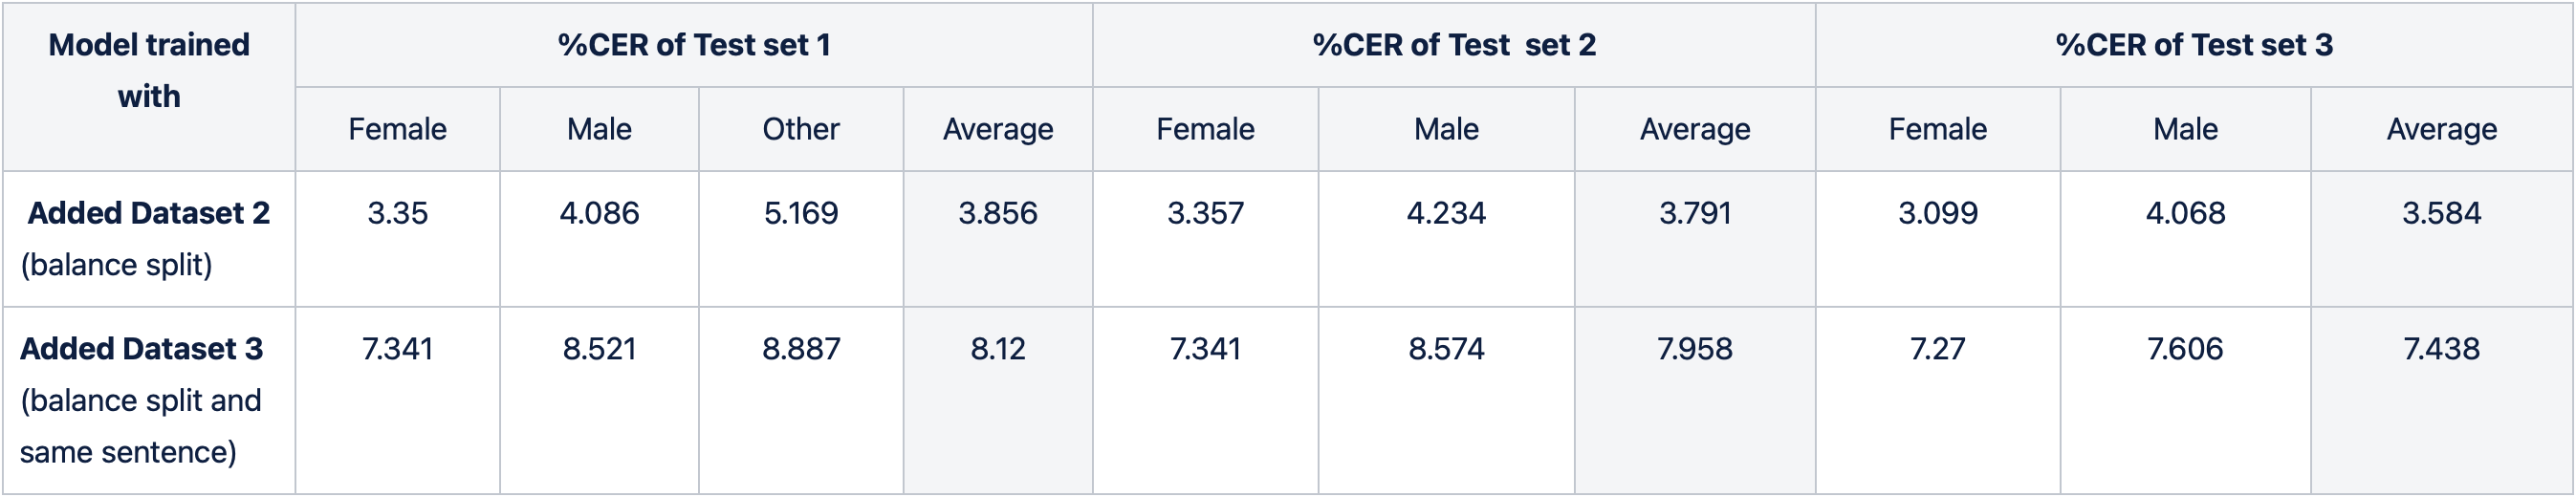

Similar to WER, the data augmentation also helps improve the performance of both new models for CER.

# 5. Further Analysis

After we trained models with greater and balanced data by filling gender by gender classifiers above, you can see that our result in every data set did not observe a performance bias between gender given there is data bias in the Common Voice 11 dataset, i.e., voice data from males are more than females? So we have 5 assumptions.

1. Maybe the diversity of females is more than male. [Maybe there are more varieties of female donating than male.]
2. Maybe female voice donation behavior gives higher quality than male. [duration]
3. Maybe the sentences from males are short and have less word variation than females. [Sentences spoken by females cover wider word variation than those of male.]
4. Maybe the male voice data have higher background noise than the female. [Clarity and quality.]
5. Maybe the male voice has some characteristics that can identify harder than the female voice characteristics.
 
Due to time limitation, we were able to experiment to prove assumption 1-4 only. We let assumption 5 for our future work.
 
In the following, we show the results of experiments below.

### 5.1 Experiment for the first assumption

Let's explore the gender distribution of each dataset. Before apply result from gender classifier, we have only 516 male and 498 female speaker from totalof 6386 speaker (most of them aren't specific their gender). After we applied result from gender classifier we have 2803 male and 3583 female speakers. For number of samples, there are 76500 samples for male and 59193 samples for female.

In [52]:
df = pd.read_csv("data/commonvoice11/annotation/validated.tsv", sep="\t")
df["client_id"].value_counts()[0:20]

/Users/kongpolc/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


765ddb5b81ef7881ddadd9c2d01f0a368270cf136bb40709cc54dfb0ac7b5eceb9992064a9c4cb70e976dd2345a1ddfd87701c3bdae4d2a41febb10d7303bbc9    25296
79e1c16f109709cef324603d132e0246ed7302f0c71f79a5f7da0513dc02a00e74a3d2506d7997f4fe681dba7fe3c9b783217271db4e7e60bbe79d11b1e81af0     9131
5c00cfb1fc9b0f86601d82194d83cfb940c3a25c8bc5167daf3f918498b3e39d2bf28cc234abeb7d12b98bb111c3521018023e4665ae4a4c9541ecd6b80d65ec     3705
4e9845ab38620c7f7816e360318bef2b93eb3adc1867d6b7f438c6fc9147fca96db584f524fd5b545f5641b281f4e2209b7fba9c7d2b7b79d07bb6b9d26a0fe2     3292
132b4f09f2e98682330263cbdc60038723baed274d48cc89edb6e96ed3aa4506933afac4fca8ee8f1fab3f170079c784b6d67bb8dbb0393ca02bddb0b7fc1578     2312
a67c2d857403fa07ae11ff6ca484fef466c68154234ae44651b422f89520a205dc5ad0f0382298470807ca92cff06cda37e437e17bf8e19a6141964bbb91fb95     2129
f6ea8fea0fb9947b878d2625f04a6b8f4e6a50577a907136f525367b2e4b6dcb0a14bb62e68d2e822868740a13a0ae11d43d85a632234e41a69819e8f616c1e7     2118
0bf48b2997faa1392615d12db5bf514ee0

In [53]:
df["client_id"].value_counts()[0:20].sum()

62281

We would like to point out here:
* Almost half of the dataset are from only 20 person.  
* 25,296 of male samples belong to a single donator.

### 5.2 Experiment for the second assumption

**Assumption**

Majority of women donating voice in this dataset speak more meticulously and slowly than men.

**Experiment**

Using the balanced dataset 3 - having similar sentences for male and female, find out the average speech duration and compare for each gender. The steps are as follow:

In [ ]:
!pip install torchaudio
!pip install pydub

In [54]:
import torchaudio
from pydub import AudioSegment
from tqdm import tqdm
import pandas as pd
import os

In [56]:
train = pd.read_csv('data/commonvoice11/annotation/dataset_3/train.csv')
dev = pd.read_csv('data/commonvoice11/annotation/dataset_3/dev.csv')
test = pd.read_csv('data/commonvoice11/annotation/dataset_3/test.csv')

- Remove leading and trailing silence from clips.

In [58]:
def detect_leading_silence(speech, silence_threshold=-50.0, chunk_size=10):
    ''' Detect and trim silence by iterating over chunks until you find the first one with sound. '''
    
    trim_ms = 0
    assert chunk_size > 0
    while speech[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(speech):
        trim_ms += chunk_size

    return trim_ms

In [59]:
def trim_clip(df, path_to_clip, dest_path):
    ''' Trim and save as new clip. '''

    for i in tqdm(range(len(df))):
        filename = df['path'][i].replace('.mp3', '.wav')

        speech = AudioSegment.from_file(os.path.join(path_to_clip, filename), format="wav")

        start_trim = detect_leading_silence(speech)
        end_trim = detect_leading_silence(speech.reverse())

        duration = len(speech) 
        trimmed_speech = speech[start_trim:duration-end_trim]

        trimmed_speech.export(os.path.join(dest_path, filename), format="wav")

In [ ]:
path_to_clip = 'data/commonvoice11/clips/clips_wav'
dest_path = 'data/commonvoice11/clips/clips_wav_trimmed'
os.makedirs(dest_path, exist_ok=True)

trim_clip(train, path_to_clip, dest_path)
trim_clip(dev, path_to_clip, dest_path)
trim_clip(test, path_to_clip, dest_path)

- See and compare the original vs. the trimmed clip

In [11]:
from IPython.display import Audio 

- Original vs. trimmed

In [18]:
Audio('data/commonvoice11/clips/clips_wav/common_voice_th_25691315.wav', autoplay=True)

In [20]:
Audio('data/commonvoice11/clips/clips_wav_trimmed/common_voice_th_25691315.wav', autoplay=True)

- Get speech duration of those processed clips.

In [62]:
def calculate_clip_duration(clip_path):
    ''' Calculates clip duration in second. '''
    try:
        speech, sr = torchaudio.load(clip_path)
        return speech.shape[-1]/sr
    except:
        return -1

In [ ]:
path_to_clip = 'data/commonvoice11/clips/clips_wav_trimmed'
train['duration'] = train['path'].apply(lambda x: calculate_clip_duration(os.path.join(path_to_clip, x.replace('.mp3','.wav'))))
dev['duration'] = dev['path'].apply(lambda x: calculate_clip_duration(os.path.join(path_to_clip, x.replace('.mp3','.wav'))))
test['duration'] = test['path'].apply(lambda x: calculate_clip_duration(os.path.join(path_to_clip, x.replace('.mp3','.wav'))))

In [74]:
train.to_csv('data/commonvoice11/annotation/dataset_3/train_trimmed.csv', index=False)
dev.to_csv('data/commonvoice11/annotation/dataset_3/dev_trimmed.csv', index=False)
test.to_csv('data/commonvoice11/annotation/dataset_3/test_trimmed.csv', index=False)

- Find the average duration for male and female.

In [9]:
train.groupby(['gender'])['duration'].mean()

gender
female    2.921746
male      3.355542
Name: duration, dtype: float64

In [10]:
dev.groupby(['gender'])['duration'].mean()

gender
female    2.811568
male      3.327649
Name: duration, dtype: float64

In [8]:
test.groupby(['gender'])['duration'].mean()

gender
female    2.892000
male      3.214079
Name: duration, dtype: float64

<b>Result:</b>

The result demonstrates that the average speech duration of male is slightly longer than that of female which does not prove the assumption of this experiment.

Therefore, individual samples are analysed further by comparing Character Error Rate (CER) and speech duration of same sentence spoken by male and female.

It is done by mapping STT prediction, WER, and CER the corresponding record. The result is in `data/commonvoice11/annotation/dataset_3/test_trimmed_with_cer.csv`.

Some of the examples are shown below.

In [78]:
test_cer = pd.read_csv('data/commonvoice11/annotation/dataset_3/test_trimmed_with_cer.csv')

- Examples of male speech having higher CER with shorter speech duration

In [79]:
test_cer[test_cer['sentence']=='ชายแก่ได้ทิ้งหนังสือ'][['path','sentence','prediction','gender','wer','cer','duration']]

path              sentence  \
146  common_voice_th_25942103.mp3  ชายแก่ได้ทิ้งหนังสือ   
147  common_voice_th_25909030.mp3  ชายแก่ได้ทิ้งหนังสือ   

                  prediction  gender  wer     cer  duration  
146    ชาย ใด ได้ที่ นัง สือ    male  0.8  0.3750     1.314  
147  ชาย แก่ ได้ คิง หนังสือ  female  0.2  0.0833     2.034

In [71]:
test_cer[test_cer['sentence']=='ด้วยความร่วมมือเราจะสามารถครอบครองโลกได้'][['path','sentence','prediction','gender','wer','cer','duration']]

path                                  sentence  \
160  common_voice_th_25731152.mp3  ด้วยความร่วมมือเราจะสามารถครอบครองโลกได้   
161  common_voice_th_25731445.mp3  ด้วยความร่วมมือเราจะสามารถครอบครองโลกได้   

                                            prediction  gender    wer     cer  \
160    เดือย ความร่วมมือ แล้ วจะ สามารถ ข้อ คง รวก ได้    male  0.750  0.3191   
161  เมื่อ ความร่วมมือ เรา จะ สามารถ ครอบ พร้อง โลก...  female  0.375  0.1702   

     duration  
160     2.612  
161     3.576

- Examples of male speech having higher CER with longer speech duration

In [72]:
test_cer[test_cer['sentence']=='ทรัสต์เพื่อการลงทุนในอสังหาริมทรัพย์'][['path','sentence','prediction','gender','wer','cer','duration']]

path                              sentence  \
182  common_voice_th_26168755.mp3  ทรัสต์เพื่อการลงทุนในอสังหาริมทรัพย์   
183  common_voice_th_26096197.mp3  ทรัสต์เพื่อการลงทุนในอสังหาริมทรัพย์   

                                    prediction  gender  wer   cer  duration  
182  ทรัสต์ เพื่อ การ ลง ทน ใน อสังหาริม ศัพท์    male  1.0  0.15     3.584  
183   ทรัสต์ เพื่อ การลงทุน ใน อสังหาริมทรัพย์  female  0.0  0.00     2.940

In [73]:
test_cer[test_cer['sentence']=='บนเพดานของห้องส่วนใหญ่ยังคงไม่บุบสลาย แต่ก็ยังเห็นร่องรอยจากความชื้น'][['path','sentence','prediction','gender','wer','cer','duration']]

path  \
214  common_voice_th_25897916.mp3   
215  common_voice_th_25916477.mp3   

                                              sentence  \
214  บนเพดานของห้องส่วนใหญ่ยังคงไม่บุบสลาย แต่ก็ยัง...   
215  บนเพดานของห้องส่วนใหญ่ยังคงไม่บุบสลาย แต่ก็ยัง...   

                                            prediction  gender  wer     cer  \
214  บน เพดาน ของ ห้อง ส่วนใหญ่ ยังคง ไม่ ห อู กส น...    male  0.4  0.1605   
215  บน พ ยา ดาน ของ ห้อง ส่วนใหญ่ ยังคง ไม่ บุ ค ส...  female  0.4  0.0988   

     duration  
214     6.806  
215     6.078

This shows that CER and speech duration are not correlated. Many instances show a decrease in CER with longer speech duration while many also show an increase in CER with longer speech duration. Hence, disproving the assumption of this experiment.

### 5.3 Experiment For The Third Assumption

**Assumption**

Maybe the sentence from males are shorter and have a word variation less than females.

**Expermient**

We used the Bag of Word method and the Number of Tokenizers of each sentence for analyzing.

In [ ]:
!pip install pythainlp
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# import essential libraries
import pandas as pd
from glob import glob
from pythainlp.tokenize import word_tokenize

In [ ]:
#get all file name
files = glob("added_gender_data/*")

In [18]:
files = ['data/commonvoice11/annotation/dataset_1/train.csv',
         'data/commonvoice11/annotation/dataset_1/dev.csv',
         'data/commonvoice11/annotation/dataset_1/test.csv',
         'data/commonvoice11/annotation/dataset_2_add_gender/train.csv',
         'data/commonvoice11/annotation/dataset_2/dev.csv',
         'data/commonvoice11/annotation/dataset_2/test.csv',
         'data/commonvoice11/annotation/dataset_3_add_gender/train.csv',
         'data/commonvoice11/annotation/dataset_3/dev.csv',
         'data/commonvoice11/annotation/dataset_3/test.csv']

In [22]:
# getting token number in each sentence
for file in files:
    df_temp = pd.read_csv(file)
    
    temp_tokenized_word = []
    no_tokens = []
    for i in range(0, len(df_temp)):
        w = word_tokenize(df_temp["sentence"][i], engine="newmm")
        temp_tokenized_word.append(w)
        no_tokens.append(len(w))
        
    df_temp["tokenized"] = temp_tokenized_word
    df_temp["no_tokens"] = no_tokens
    
    filename = '/'.join(file.split('/')[-2:]).replace('.csv','.xlsx')
    dest_path = 'data/commonvoice11/analysis/word_coverage/export'
    os.makedirs(os.path.join(dest_path, filename.split('/')[0]), exist_ok=True)
    print(os.path.join(dest_path, filename))
    df_temp.to_excel(os.path.join(dest_path, filename))

data/commonvoice11/analysis/word_coverage/export/dataset_1/train.xlsx
data/commonvoice11/analysis/word_coverage/export/dataset_1/dev.xlsx
data/commonvoice11/analysis/word_coverage/export/dataset_1/test.xlsx
data/commonvoice11/analysis/word_coverage/export/dataset_2/dev.xlsx
data/commonvoice11/analysis/word_coverage/export/dataset_2/test.xlsx
data/commonvoice11/analysis/word_coverage/export/dataset_3/dev.xlsx
data/commonvoice11/analysis/word_coverage/export/dataset_3/test.xlsx


In [ ]:
print(df_temp.describe())

        Unnamed: 0   Unnamed: 0.1    up_votes  down_votes  accents  \
count   148.000000     148.000000  148.000000  148.000000      0.0   
mean   3781.202703   89083.500000    2.027027    0.081081      NaN   
std    2007.419808   28323.368132    0.162713    0.273886      NaN   
min      85.000000      76.000000    2.000000    0.000000      NaN   
25%    2326.250000   72954.500000    2.000000    0.000000      NaN   
50%    3877.000000   95149.000000    2.000000    0.000000      NaN   
75%    5617.750000  111189.500000    2.000000    0.000000      NaN   
max    6789.000000  131985.000000    3.000000    1.000000      NaN   

          weights   no_tokens  
count  148.000000  148.000000  
mean     0.305570    6.675676  
std      0.083013    3.456663  
min      0.222838    1.000000  
25%      0.222838    5.000000  
50%      0.305570    6.000000  
75%      0.388301    9.000000  
max      0.388301   15.000000  


In [ ]:
# Get Bag of Word, Grupby gender
import pandas as pd
import numpy as np
import collections
from tqdm import tqdm

# Define function and parameter
def calculateBOW(wordset,l_doc):
    tf_diz = dict.fromkeys(wordset,0)
    for word in l_doc:
        tf_diz[word]=l_doc.count(word)
    return tf_diz

bow_m = []
bow_f = []
word_sets_m = []
word_sets_f = []
docs = []
for file in files:
    df_temp = pd.read_excel(file)
    df_male = df_temp[df_temp["gender"]=="male"]
    df_male.reset_index(inplace = True, drop=True)
    df_female = df_temp[df_temp["gender"]=="female"]
    df_female.reset_index(inplace = True, drop=True)

    temp_tokenized_word_m = []
    word_set_m = []
    for i in range(0, len(df_male)):
        w = word_tokenize(df_male["sentence"][i], engine="newmm")
        for token in w:
            temp_tokenized_word_m.append(token)
    word_set_m = word_set_m + temp_tokenized_word_m #collect all word
    bow_m.append(temp_tokenized_word_m) #collect all word of each file

    temp_tokenized_word_f = []

    word_set_f = []
    for i in range(0, len(df_female)):
        w = word_tokenize(df_female["sentence"][i], engine="newmm")
        for token in w:
            temp_tokenized_word_f.append(token)
    word_set_f = word_set_f + temp_tokenized_word_f #collect all word
    bow_f.append(temp_tokenized_word_f) #collect all word of each file

    docs.append(file.split("/")[1]) #collect file name of each bow

    word_sets_m.append(word_set_m)
    word_sets_f.append(word_set_f)



In [ ]:
# call get BOW function
df_bows_m = []
df_bows_f = []
for i in tqdm(range(0, len(files))):
    bow_m_dict= calculateBOW(word_sets_m[i], bow_m[i] )
    bow_f_dict = calculateBOW(word_sets_f[i], bow_f[i] )
    
    df_bows_m.append(pd.DataFrame(bow_m_dict, index=[i]))
    df_bows_f.append(pd.DataFrame(bow_f_dict, index=[i]))


100%|██████████| 9/9 [9:59:45<00:00, 3998.36s/it]


In [ ]:
# Export file
df_m = pd.concat(df_bows_m)
df_m["file"] = docs
df_m = df_m.T
# print(df_m)
df_f = pd.concat(df_bows_f)
df_f["file"] = docs
df_f = df_f.T
# print(df_f)

# Export file for analysing further in MS Excel
writer = pd.ExcelWriter("data/commonvoice11/analysis/word_coverage/export/bow_analysis.xlsx", engine = 'xlsxwriter')
df_m.to_excel(writer, sheet_name = 'male')
df_f.to_excel(writer, sheet_name = 'female')

writer.save()
writer.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
/usr/local/lib/python3.7/dist-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


**Result** 

In this section, we report the overall result of the word coverage analysis.

- the number of words in each sentence from `data/commonvoice11/analysis/word_coverage/export` (`data/commonvoice11/analysis/word_coverage/pivotted/avg_word_coverage_analysis.xlsx`)

Result: Word frequency of each sentence
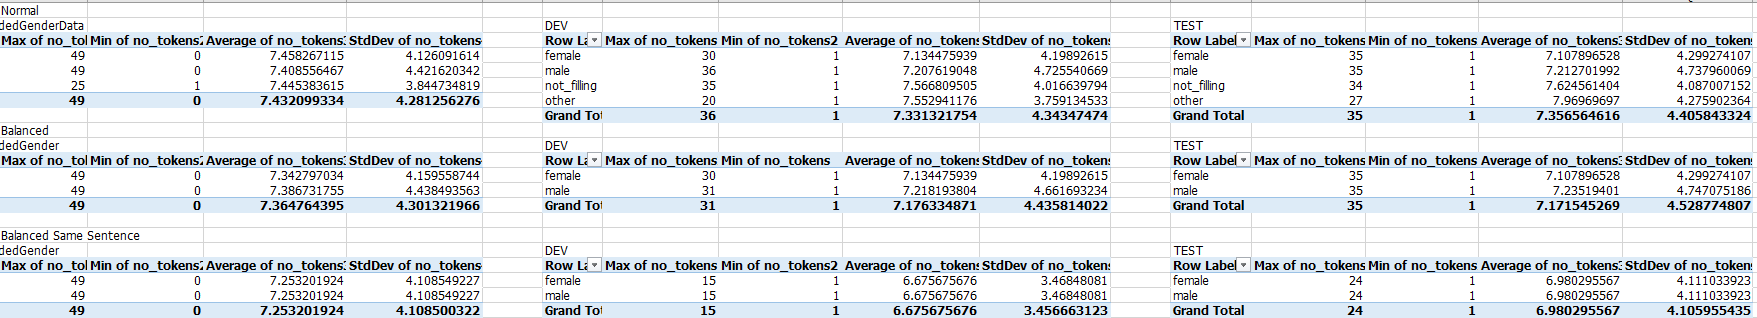

- the Bag of words of added data (`data/commonvoice11/analysis/word_coverage/pivotted/word_coverage_analysis.xlsx`)

Result: Bag of Word (Frequency of unique words in each data)
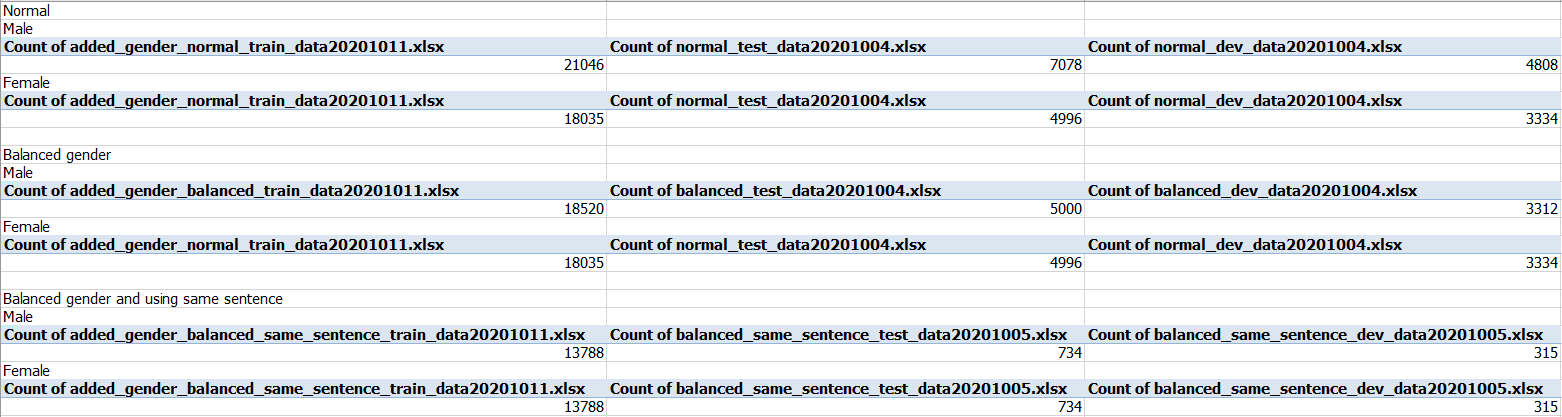

We found the number of words in sentences from the male and female sentences is not quite different. But in the word variation, males have a variation of words more than females.

### 5.4 Experiment For the Fourth Assumption

**Assumption** 

We assumed that there may be background noise in male data more than those found in female. 

**Experiment**

We selected some files from the two genders, about 200 for each set of data, and listened to them file by file. 

**Result**

We found that there was background noise in male data more than female. However, the background noise does not overpower the speech. Significantly, the majority of male data having background noises came from one ID and this ID donated his voice about one-third of male data. Moreover, the interesting points we found while listening to the data was that females seemed to speak slower and clearer than males. Males sometimes rushed their words. As a result, this could be one reason why the model can recognize female voice better than male voice although the dataset is one fourth smaller than male dataset.

# 6. Conclusion

In our experiment, we focused on the gender bias in common voice 11 dataset as the distribution of gender-labeled data is not equal. The amount of female-labeled data is much smaller than that of male-labeled data.

After we trained the model with common voice 11 data, it showed that the model could better recognize the female voice in most cases of our experiments even though the female-labeled data was about one fourth smaller when compared to male-labeled data.

We tried to find out why model was good for females rather than males and found that the reason might come from the quality of data and the amount of people donating their voice rather than quantity of data. It seemed that the more people donated, the more variation of voice or knowledge model can learn.

We applied our gender classification model to identify gender for “not filling” class. The accuracy of our gender classification model achieved 95% for F1 score on our test set. The results suggested that the number of women donating their voice is much more than men, 3,583 and 2,803 respectively while the number of files of female dataset is about one-fourth smaller than male dataset, 76,500 and 59,193, respectively.

Therefore, this led to the conclusion that the diversity and quality of voices are more crucial and important than the quantity (or amount of data). Although the size of data is large but the source of data comes from few people, the model does not learn well and may not improve much.

# 7. Future work

Since we have learned that the number of various voices is important, we plan to not include all amount of data of the one who donated much more data than others but try to balance the dataset for training data.

Moreover, we assumed that male voice tends to have some characteristics like low-pitched voice that are harder for model to recognize than female voice.

We may use some tools to estimate the fundamental frequency (F0) of each voice as F0 is related to pitch and then do the experiment from the training data grouped by F0.